# Evaluation of enthalpy to temperature conversion methods

This notebook compares different methods for the conversion of enthalpy to temperature.
The evaluation is performed in terms of computational cost and accuracy.

The following methods are considered:
- **Newton's method**
  
    Newton's method is an iterative algorithm for finding a root of a function $f(x)$, starting from an initial guess.  
    The iterative formula to update the guess root is:

    $$
    x_{n+1} = x_{n} - \frac{f(x_{n})}{f'(x_{n})},
    $$

    where subsctrits $n$ and $n+1$ refer in the order to the old and new iterations. 

    To find the temperature $T_{i+1}$ corresponding to a certain enthalpy rise $\Delta{h_{i, i+1}}$, 
    given the initial temperature $T_i$, the following function is considered:

    $$
    f(T_{i+1}) = \Delta{h_{i, i+1}} - \Delta{h}^*(T_{i+1}),
    $$

    where $\Delta{h}^*(T_{i+1})$ only depends on $T_{i+1}$ and can be calculated with a correlation.

    The iteration formula is then:

    $$
    T_{i+1, n+1} = T_{i+1, n} + \frac{\Delta{h_{i,i+1} - \Delta{h}^*(T_{i+1, n})}}{c_p(T_{i+1, n})}.
    $$

- **_lbh15_**

    _lbh15_ is a python-based library for Lead, Bismuth and LBE material properties. Given a certain temperature $T$, _lbh15_ uses a correlation to find the corresponding $\Delta{h}(T)$, which is computed with respect to the melting enthalpy. 

- **Table interpolation**

    This method relies on the _NumPy_ function `interp()` to perform linear interpolation. It reads a reference dataset provided from a _csv_ file containing a series of temperatures and the corresponding enthalpies (calculated relative to the melting enthalpy). 

- **Fitting polynomial**
  
    As an alternative to the previous method, a polynomial built from the same dataset can be used. This approach is based on the _NumPy_ functions `polyfit()` and `polyval()`, that are generally less computationally expensive than the _NumPy_ function `interp()`.

    Using `polyval` is also more efficient than defining a dedicated function with an algebraic relation, because the _NumPy_ function is based on the Horner scheme.  



## Methods' evaluation
The methods described above are implemented in the file _temp_from_h.py_, and imported in the following code section. 

Their computational time and accuracy is evaluated with the `eval_time` and `eval_accuracy` functions, imported from the file _time_and_accuracy.py_.

Accuracy is estimated against a reference dataset: _lead_ref.csv_.

In [ ]:
import importlib
import _commons
importlib.reload(_commons)
from temp_from_h import newton_method, lbh15_method, table_method, poly_method
from time_and_accuracy import eval_time, eval_accuracy, summarize_results
from plots import plot_table_evalutation, plot_polynomium_results
from plots import plot_accuracy_comparison
from _commons import DB_SIZES, DEG
import numpy as np 
from tabulate import tabulate
import os

reference = np.genfromtxt(os.path.join('data','lead_ref.csv'), delimiter=',')

## Table interpolation accuracy and reference dataset
The precision of the table method depends on the width of the dataset used for interpolation. Smaller temperature increments between consecutive data points generally lead to higher interpolation accuracy. To evaluate how accuracy is influenced by the number of data, different datasets (collecting from 500 to 5000 temperature-enthalpy couples) have been created and will be compared in terms of computational time and accuracy against a reference dataset of 5000 points. 

In [2]:
results_table = {}
results_table_h = {}
for s in DB_SIZES:
    results_table[s] = summarize_results(table_method, reference, s)   

Accuracy and computational time estimated for `table_method`:

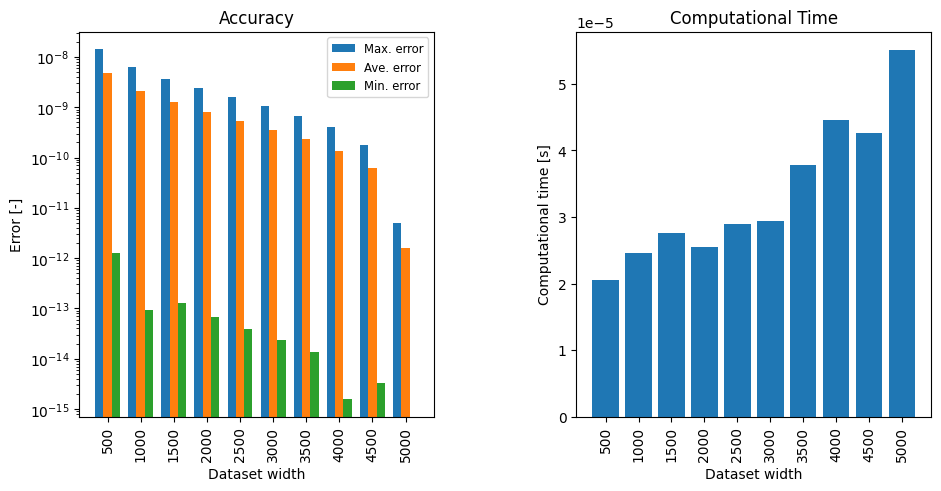

In [3]:
plot_table_evalutation(results_table)

## Fitting polynomial
In this section, a polynomial is built fitting a dataset of 5000 temperature-enthalpy couples. The _NumPy_ functions `polyfit` and `polyval` are used. 
Different degrees of the polynomial are tested and compared to the most 
accurate case of the _Table method_ (i.e. `interp` function with 5000 data 
points). 

Note that according to the `numpy.polyfit` documentation page, the polynomial coefficients' fitting may be badly conditioned when the degree of the polynomial is large. When this happens, a _RankWarning_ is issued.

/tmp/ipykernel_39687/2225256157.py:11: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
/tmp/ipykernel_39687/2225256157.py:11: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
/tmp/ipykernel_39687/2225256157.py:11: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
/tmp/ipykernel_39687/2225256157.py:11: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
/tmp/ipykernel_39687/2225256157.py:11: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
/tmp/ipykernel_39687/2225256157.py:11: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
/tmp/ipykernel_39687/2225256157.py:11: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
/tmp/i

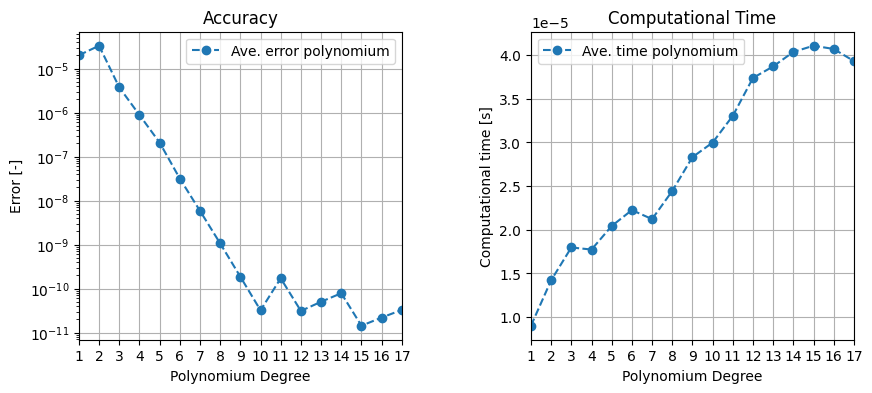

In [4]:
s = DB_SIZES[-1]
data_path = f'lead_{s}.csv'

data = np.genfromtxt(os.path.join('data', data_path), delimiter=',')

eave_poly = np.zeros(DEG-1)

time_poly = np.zeros(DEG-1)

for dd in range(1, DEG):
    coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
    coeffs_h2T = np.polyfit(data[:,1], data[:,0], deg=dd)
    
    errors = eval_accuracy(poly_method, reference, coeffs_T2h=coeffs_T2h, 
                           coeffs_h2T=coeffs_h2T)
    eave_poly[dd-1] = np.mean(errors)
    time_poly[dd-1] = eval_time(poly_method, coeffs_T2h=coeffs_T2h, 
                                coeffs_h2T=coeffs_h2T)
    
plot_polynomium_results(eave_poly, time_poly)

_NumPy_ issues a _RankWarning_ for polynomials of degree >= 11. As a consequence, the 10-th degree polynomial will be hereafter considered.

## Computational time 

The average computational time is estimated for all the considered methods. 

Each method requires an array of temperatures and an array of enthalpy rises. For the scope of this analysis a temperature of 700 K and an enthalpy rise of 100 J/kg are used.

The largest dataset for interpolation has been used for the Table interpolation method and for the polynomial fitting.

In [8]:
data_path = f'lead_{DB_SIZES[-1]}.csv'
table = [["Newton", eval_time(newton_method)],
         ["lbh15", eval_time(lbh15_method)],
         ["Table", results_table[DB_SIZES[-1]]['time']],
         ["Polynomium (10 deg)", time_poly[9]]]

print(tabulate(table, headers=["Method", "Computational time"], 
               tablefmt="github"))

| Method              |   Computational time |
|---------------------|----------------------|
| Newton              |          0.000397897 |
| lbh15               |          0.0142746   |
| Table               |          5.51151e-05 |
| Polynomium (10 deg) |          2.99877e-05 |


## Accuracy evaluation

A vector of $n$ temperatures `tt_ref` is created to test the accuracy of the Newton and Table interpolation methods.
For each pair of consecutive elements in `tt_ref` ($T_i$ and $T_{i+1}$), the corresponding enthalpy rise $\Delta h(T_i, T_{i+1})$ is calculated with lbh15, producing a vector of $n-1$ enthalpy values `hh_ref`.

These vectors are passed as parameters to the two methods. The results are compared with the first vector, which alse serves as a reference.

A function `eval_accuracy` is created to evaluate a method's accuracy given a set of reference data.

In the following script, Newton and table interpolation methods' accuracy is evaluated against a 5000 points reference dataset. Table interpolation is based on a 5000 points dataset.

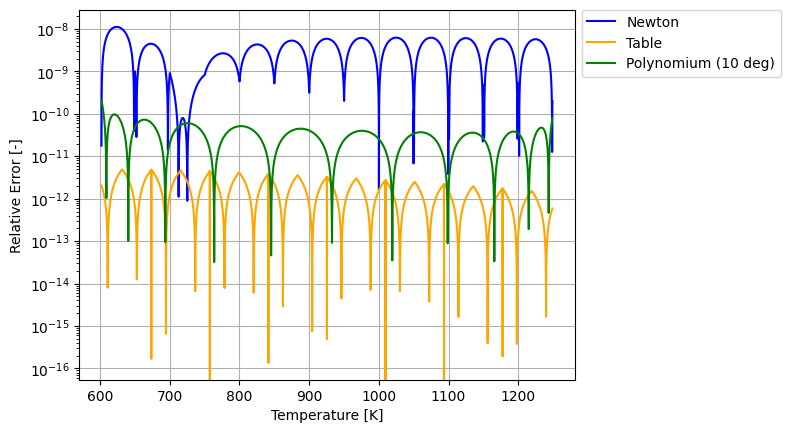

In [14]:
path = f'lead_{DB_SIZES[-1]}.csv'
err_newton = eval_accuracy(newton_method, reference)
err_table = eval_accuracy(table_method, reference, data_path=path)
err_poly = eval_accuracy(poly_method, reference, 
                           coeffs_T2h=np.polyfit(data[:,0], data[:,1], deg=10), 
                           coeffs_h2T=np.polyfit(data[:,1], data[:,0], deg=10))
plot_accuracy_comparison(reference, err_newton, err_table, err_poly)